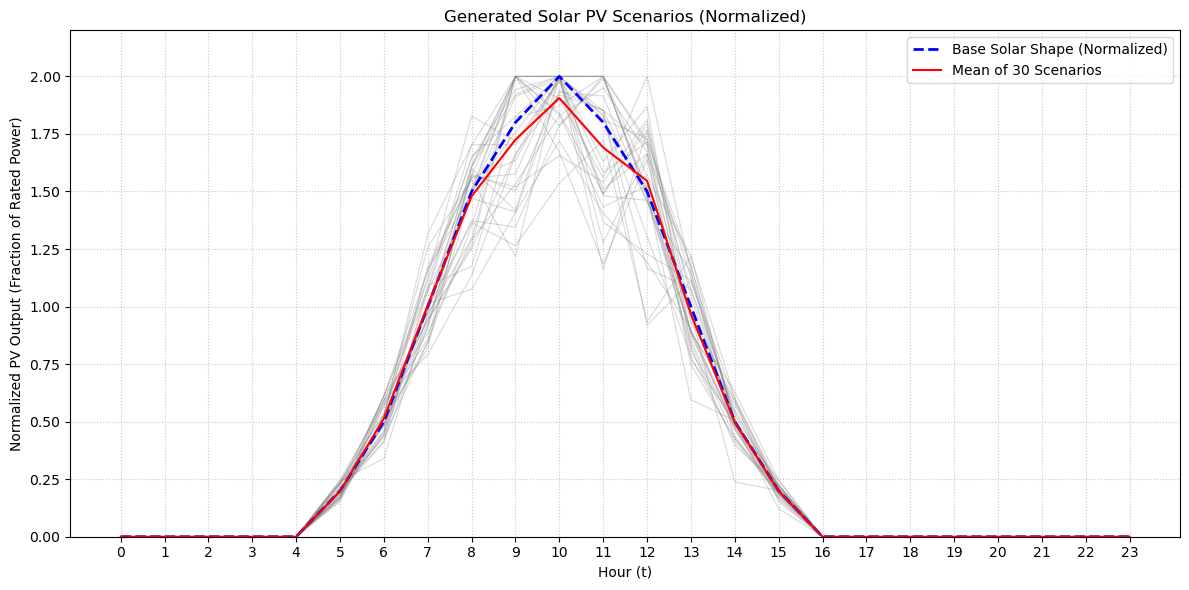

--- Running optimization for DRCCP_ALPHA = 0.2 ---
Set parameter Username
Set parameter LicenseID to value 2621942
Academic license - for non-commercial use only - expires 2026-02-14
Set parameter LogToConsole to value 0
Optimal/Suboptimal objective value for Alpha=0.2: 4.5491
------------------------------------------------------------
--- Running optimization for DRCCP_ALPHA = 0.4 ---
Set parameter LogToConsole to value 0
Optimal/Suboptimal objective value for Alpha=0.4: 8.3642
------------------------------------------------------------
--- Running optimization for DRCCP_ALPHA = 0.6 ---
Set parameter LogToConsole to value 0
Optimal/Suboptimal objective value for Alpha=0.6: 10.0825
------------------------------------------------------------
--- Running optimization for DRCCP_ALPHA = 0.8 ---
Set parameter LogToConsole to value 0
Optimal/Suboptimal objective value for Alpha=0.8: 11.5215
------------------------------------------------------------


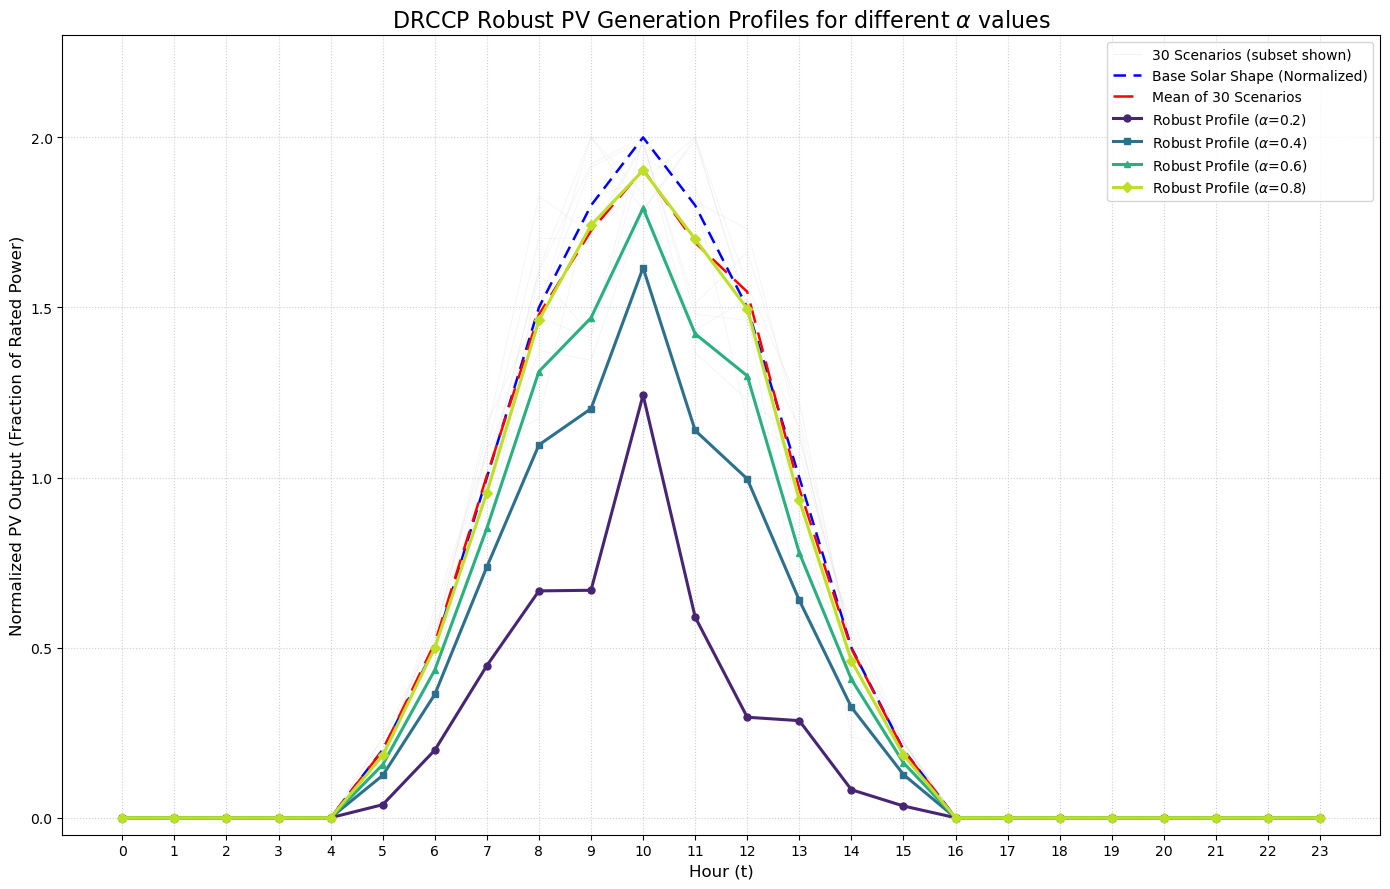


--- P_pv_robust for Alpha = 0.2 ---
------------------------------------------
| 시간 (t) | P_pv_robust (하한) |
------------------------------------------
|        0 |              0.0000 |
|        1 |              0.0000 |
|        2 |              0.0000 |
|        3 |              0.0000 |
|        4 |              0.0000 |
|        5 |              0.0383 |
|        6 |              0.1986 |
|        7 |              0.4469 |
|        8 |              0.6668 |
|        9 |              0.6686 |
|       10 |              1.2426 |
|       11 |              0.5898 |
|       12 |              0.2954 |
|       13 |              0.2853 |
|       14 |              0.0823 |
|       15 |              0.0345 |
|       16 |              0.0000 |
|       17 |              0.0000 |
|       18 |              0.0000 |
|       19 |              0.0000 |
|       20 |              0.0000 |
|       21 |              0.0000 |
|       22 |              0.0000 |
|       23 |              0.0000 |
-------

In [1]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt # 시각화를 위해 추가
from scipy.optimize import minimize_scalar # Wasserstein 반경 계산을 위해 추가

# --------------------------------------------------------------------------
# 1. 초기 파라미터 설정 및 태양광 시나리오 생성/시각화
# --------------------------------------------------------------------------
solar_shape = [0]*5 + [20,50,100,150,180,200,180,150,100,50,20] + [0]*8
T = range(24)  # 0부터 23까지의 시간 인덱스 (총 24시간)

N_SCENARIOS = 30
# DRCCP_ALPHA 는 아래 루프에서 설정됩니다.
# DRCCP_EPSILON 은 아래 루프에서 시간별로 계산됩니다.
SOLAR_NOISE_STD_FRACTION = 0.15

if solar_shape and any(s > 0 for s in solar_shape):
    MAX_SOLAR_PROFILE_PERCENT = float(max(solar_shape))
else:
    MAX_SOLAR_PROFILE_PERCENT = 0.0

solar_scenarios_normalized = np.zeros((N_SCENARIOS, len(T)))
base_solar_profile_normalized = np.array(solar_shape) / 100.0

max_norm_profile = MAX_SOLAR_PROFILE_PERCENT / 100.0 if MAX_SOLAR_PROFILE_PERCENT > 0 else 0.0
if max_norm_profile == 0 and np.any(base_solar_profile_normalized > 0):
    max_norm_profile = np.max(base_solar_profile_normalized)

for scenario_idx in range(N_SCENARIOS):
    for t_idx in T:
        nominal_shape_at_t_frac = base_solar_profile_normalized[t_idx]
        if nominal_shape_at_t_frac == 0:
            solar_scenarios_normalized[scenario_idx, t_idx] = 0.0
        else:
            noise_std_dev = SOLAR_NOISE_STD_FRACTION * nominal_shape_at_t_frac
            noise = np.random.normal(0, noise_std_dev)
            noisy_shape_frac = nominal_shape_at_t_frac + noise
            solar_scenarios_normalized[scenario_idx, t_idx] = np.clip(noisy_shape_frac, 0, max_norm_profile if max_norm_profile > 0 else 1.0)

# --- 초기 태양광 발전 시나리오 시각화 ---
plt.figure(figsize=(12, 6))
for i in range(N_SCENARIOS):
    plt.plot(T, solar_scenarios_normalized[i, :], color='gray', alpha=0.3, linewidth=0.8)
plt.plot(T, base_solar_profile_normalized, color='blue', linewidth=2, linestyle='--', label='Base Solar Shape (Normalized)')
mean_scenario = np.mean(solar_scenarios_normalized, axis=0)
plt.plot(T, mean_scenario, color='red', linewidth=1.5, label=f'Mean of {N_SCENARIOS} Scenarios')
plt.title('Generated Solar PV Scenarios (Normalized)')
plt.xlabel('Hour (t)')
plt.ylabel('Normalized PV Output (Fraction of Rated Power)')
plt.xticks(list(T))
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(bottom=0)
if max_norm_profile > 0:
    plt.ylim(top=max_norm_profile * 1.1)
plt.tight_layout()
plt.show()

# P_max, P_min 은 Gurobi 모델 변수 설정 전에 계산되어야 함
P_max = np.max(solar_scenarios_normalized, axis=0)
P_min = np.min(solar_scenarios_normalized, axis=0)

# --------------------------------------------------------------------------
# 2. 여러 DRCCP_ALPHA 값에 대한 최적화 및 결과 저장
# --------------------------------------------------------------------------
alphas_to_test = [0.2, 0.4, 0.6, 0.8]
all_robust_profiles = {} # 각 alpha에 대한 P_pv_robust 값을 저장할 딕셔너리

FALLBACK_EPSILON = 0.1 # D 계산 실패 시 사용할 기본 epsilon 값

for current_alpha_value in alphas_to_test:
    print(f"--- Running optimization for DRCCP_ALPHA = {current_alpha_value} ---")
    DRCCP_ALPHA = current_alpha_value # 현재 루프의 Alpha 값

    # --- 각 시간 t에 대해 Wasserstein ball radius를 사용하여 DRCCP_EPSILON 계산 ---
    if not (0 < DRCCP_ALPHA < 1):
        raise ValueError("DRCCP_ALPHA는 epsilon 계산을 위해 (0, 1) 사이 값이어야 합니다.")

    log_term_for_epsilon_calc = np.log(1.0 / DRCCP_ALPHA)
    DRCCP_EPSILONS_PER_T_runtime = []

    for t_idx in T:
        if base_solar_profile_normalized[t_idx] == 0:
            DRCCP_EPSILONS_PER_T_runtime.append(0.0)
            continue

        samples_at_t = solar_scenarios_normalized[:, t_idx]
        mu_hat_at_t = np.mean(samples_at_t)
        N_runtime = N_SCENARIOS

        diff_sq = (samples_at_t - mu_hat_at_t)**2

        def d_objective_func_core(rho):
            if rho <= 1e-9: return np.inf
            try:
                exp_terms = np.exp(rho * diff_sq)
            except OverflowError:
                return np.inf
            mean_of_exp_terms = np.mean(exp_terms)
            if mean_of_exp_terms <= 1e-9: return np.inf # log 인수는 양수여야
            log_of_mean_exp = np.log(mean_of_exp_terms)
            val_inside_sqrt = (2.0 / rho) * (1.0 + log_of_mean_exp)
            if val_inside_sqrt < 0: return np.inf # D^2은 음수가 될 수 없음
            return val_inside_sqrt

        opt_result_rho = minimize_scalar(d_objective_func_core, bounds=(1e-7, 200), method='bounded')
        D_t_squared = opt_result_rho.fun

        if not opt_result_rho.success or D_t_squared == np.inf or D_t_squared < 0:
            print(f"경고: Alpha={DRCCP_ALPHA}, t={t_idx}에서 D_t^2 계산 실패 ({D_t_squared:.4e}). Fallback epsilon ({FALLBACK_EPSILON:.2f}) 사용.")
            DRCCP_EPSILONS_PER_T_runtime.append(FALLBACK_EPSILON)
            continue
        
        D_t = np.sqrt(D_t_squared)
        epsilon_t = D_t * np.sqrt((1.0 / N_runtime) * log_term_for_epsilon_calc)
        DRCCP_EPSILONS_PER_T_runtime.append(epsilon_t)
    
    # print(f"계산된 시간별 DRCCP_EPSILON 값 (Alpha={DRCCP_ALPHA}): {[f'{x:.4f}' for x in DRCCP_EPSILONS_PER_T_runtime]}")

    # --- Gurobi 모델 정의 및 최적화 ---
    m = gp.Model(f"DRCCP_Alpha_{DRCCP_ALPHA:.1f}")
    m.Params.LogToConsole = 0 # Gurobi 로그 출력을 억제

    P_pv_robust = m.addVars(T, lb=0, ub=max_norm_profile, name="P_pv_robust")
    v_drccp     = m.addVars(T, lb=-gp.GRB.INFINITY, name="v_drccp")
    z_drccp     = m.addVars(T, N_SCENARIOS, lb=0, name="z_drccp")
    w_drccp     = m.addVars(T, N_SCENARIOS, lb=0, ub=1.0, name="w_drccp")
    r_max_drccp = m.addVars(T, N_SCENARIOS, lb=0, name="r_max_drccp")
    r_min_drccp = m.addVars(T, N_SCENARIOS, lb=0, name="r_min_drccp")

    for t_idx in T:
        if base_solar_profile_normalized[t_idx] == 0:
            P_pv_robust[t_idx].ub = 0.0
            v_drccp[t_idx].lb = 0.0
            v_drccp[t_idx].ub = 0.0
            for s_idx in range(N_SCENARIOS):
                z_drccp[t_idx, s_idx].ub = 0.0
                w_drccp[t_idx, s_idx].ub = 0.0
                r_max_drccp[t_idx, s_idx].ub = 0.0
                r_min_drccp[t_idx, s_idx].ub = 0.0

    m.setObjective(gp.quicksum(P_pv_robust[t] for t in T), gp.GRB.MAXIMIZE)

    for t_idx in T:
        if base_solar_profile_normalized[t_idx] > 0:
            m.addConstr(
                DRCCP_ALPHA * N_SCENARIOS * v_drccp[t_idx] -
                gp.quicksum(z_drccp[t_idx, s_idx] for s_idx in range(N_SCENARIOS)) >=
                DRCCP_EPSILONS_PER_T_runtime[t_idx] * N_SCENARIOS,
                name=f"DRCCP_C1_t{t_idx}"
            )
            for s_idx in range(N_SCENARIOS):
                P_hat_km = solar_scenarios_normalized[s_idx, t_idx]
                m.addConstr(
                    (-P_pv_robust[t_idx] + P_hat_km) * w_drccp[t_idx, s_idx] -
                    (P_max[t_idx]- P_hat_km) * r_max_drccp[t_idx, s_idx] +
                    (P_min[t_idx] - P_hat_km) * r_min_drccp[t_idx, s_idx] >=
                    v_drccp[t_idx] - z_drccp[t_idx, s_idx],
                    name=f"DRCCP_C2_t{t_idx}_s{s_idx}"
                )
                m.addConstr(
                    -w_drccp[t_idx, s_idx] - r_max_drccp[t_idx, s_idx] + r_min_drccp[t_idx, s_idx] <= 1,
                    name=f"DRCCP_C3a_t{t_idx}_s{s_idx}"
                )
                m.addConstr(
                    -w_drccp[t_idx, s_idx] - r_max_drccp[t_idx, s_idx] + r_min_drccp[t_idx, s_idx] >= -1,
                    name=f"DRCCP_C3b_t{t_idx}_s{s_idx}"
                )
    
    m.update()
    m.params.NonConvex = 2
    m.optimize()

    if m.status == gp.GRB.OPTIMAL or m.status == gp.GRB.SUBOPTIMAL:
        P_pv_robust_values = [P_pv_robust[t].X for t in T]
        all_robust_profiles[DRCCP_ALPHA] = P_pv_robust_values
        print(f"Optimal/Suboptimal objective value for Alpha={DRCCP_ALPHA:.1f}: {m.ObjVal:.4f}")
    else:
        print(f"Optimization FAILED for Alpha={DRCCP_ALPHA:.1f}. Status: {m.status}")
        all_robust_profiles[DRCCP_ALPHA] = [0.0] * len(T) # 실패 시 0으로 채움
        if m.status == gp.GRB.INFEASIBLE:
            print("Model is infeasible. Computing IIS...")
            m.computeIIS()
            iis_file = f"model_iis_alpha_{DRCCP_ALPHA:.1f}.ilp"
            m.write(iis_file)
            print(f"IIS written to {iis_file}")

    print("-" * 60)

# --------------------------------------------------------------------------
# 3. 모든 Alpha 값에 대한 결과 종합 플로팅
# --------------------------------------------------------------------------
plt.figure(figsize=(14, 9))

# 참고용: 원본 태양광 시나리오 중 일부 플롯
num_scenarios_to_plot = min(N_SCENARIOS, 10)
for i in range(num_scenarios_to_plot):
    plt.plot(T, solar_scenarios_normalized[i, :], color='lightgray', alpha=0.25, linewidth=0.6, label='_nolegend_')
if N_SCENARIOS > num_scenarios_to_plot:
    plt.plot([], [], color='lightgray', alpha=0.3, linewidth=0.7, label=f'{N_SCENARIOS} Scenarios (subset shown)')

# 참고용: 기본 태양광 패턴 및 평균 시나리오 플롯
plt.plot(T, base_solar_profile_normalized, color='blue', linewidth=1.8, linestyle='--', dashes=(5, 3), label='Base Solar Shape (Normalized)')
mean_scenario = np.mean(solar_scenarios_normalized, axis=0)
plt.plot(T, mean_scenario, color='red', linewidth=1.8, linestyle='-.', dashes=(8, 4), label=f'Mean of {N_SCENARIOS} Scenarios')

# 각 Alpha 값에 대한 P_pv_robust 플롯
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(alphas_to_test))) # 색상 범위 조정
markers = ['o', 's', '^', 'D', 'v', '<', '>'] 

for idx, alpha_val in enumerate(alphas_to_test):
    if alpha_val in all_robust_profiles and all_robust_profiles[alpha_val]:
        plt.plot(T, all_robust_profiles[alpha_val], color=colors[idx], linewidth=2.2, 
                 marker=markers[idx % len(markers)], markersize=5, 
                 label=f'Robust Profile ($\\alpha$={alpha_val:.1f})') # LaTeX 스타일로 alpha 표시

plt.title('DRCCP Robust PV Generation Profiles for different $\\alpha$ values', fontsize=16)
plt.xlabel('Hour (t)', fontsize=12)
plt.ylabel('Normalized PV Output (Fraction of Rated Power)', fontsize=12)
plt.xticks(list(T))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='best', fontsize=10) # 범례 위치 'best'로 자동 조정
plt.ylim(bottom=-0.05)

top_y_limit = 0.0
if max_norm_profile > 0:
    top_y_limit = max_norm_profile * 1.15 # 약간 더 여유
elif np.any(base_solar_profile_normalized > 0):
    top_y_limit = (max(base_solar_profile_normalized) * 1.15 if max(base_solar_profile_normalized) > 0 else 1.0)
else:
    top_y_limit = 1.0

if all_robust_profiles:
    max_robust_val = 0
    for profile in all_robust_profiles.values():
        if profile:
             max_robust_val = max(max_robust_val, max(profile))
    top_y_limit = max(top_y_limit, max_robust_val * 1.15, 0.1)

plt.ylim(top=top_y_limit if top_y_limit > 0.05 else 1.0) # y 상한이 너무 작아지지 않도록

plt.tight_layout()
plt.show()

# 상세 P_pv_robust 값 출력 (선택 사항)
for alpha_val, robust_profile in all_robust_profiles.items():
    if robust_profile: # 프로파일이 있는 경우 (최적화 성공 시)
        print(f"\n--- P_pv_robust for Alpha = {alpha_val:.1f} ---")
        print("------------------------------------------")
        print("| 시간 (t) | P_pv_robust (하한) |")
        print("------------------------------------------")
        for t_idx in T:
            print(f"| {t_idx:8d} | {robust_profile[t_idx]:19.4f} |")
        print("------------------------------------------\n")


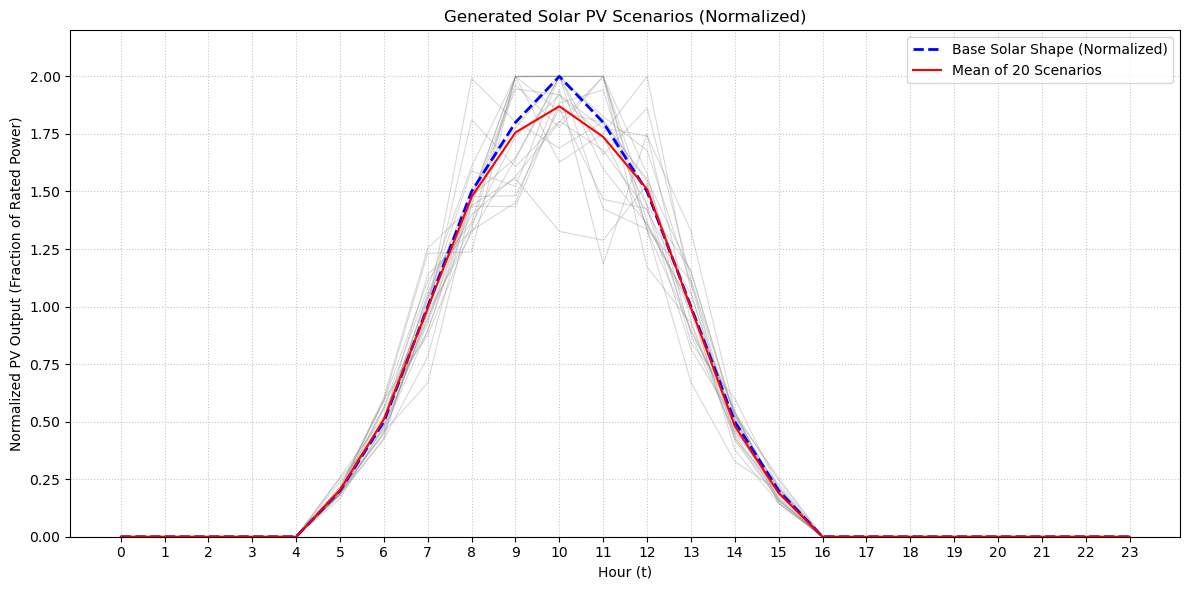

계산된 시간별 DRCCP_EPSILON 값: [0.0, 0.0, 0.0, 0.0, 0.0, 0.005383534696237046, 0.0068734536353234395, 0.01886165563116737, 0.02832716972450709, 0.020790127417339033, 0.02956629889664493, 0.03193558967551711, 0.02794128165315161, 0.0201022240911005, 0.008857446348229422, 0.005621102667665148, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [2]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt # 시각화를 위해 추가
from scipy.optimize import minimize_scalar


solar_shape = [0]*5 + [20,50,100,150,180,200,180,150,100,50,20] + [0]*8
T = range(24)  # 0부터 23까지의 시간 인덱스 (총 24시간)

N_SCENARIOS = 20
SOLAR_NOISE_STD_FRACTION = 0.15

if solar_shape and any(s > 0 for s in solar_shape):
    MAX_SOLAR_PROFILE_PERCENT = float(max(solar_shape))
else:
    MAX_SOLAR_PROFILE_PERCENT = 0.0

solar_scenarios_normalized = np.zeros((N_SCENARIOS, len(T)))
base_solar_profile_normalized = np.array(solar_shape) / 100.0

max_norm_profile = MAX_SOLAR_PROFILE_PERCENT / 100.0 if MAX_SOLAR_PROFILE_PERCENT > 0 else 0.0
if max_norm_profile == 0 and np.any(base_solar_profile_normalized > 0):
    max_norm_profile = np.max(base_solar_profile_normalized)



for scenario_idx in range(N_SCENARIOS):
    for t_idx in T:
        nominal_shape_at_t_frac = base_solar_profile_normalized[t_idx]
        # 발전량이 0인 시간에는 노이즈도 0, 시나리오 값도 0으로 유지
        if nominal_shape_at_t_frac == 0:
            solar_scenarios_normalized[scenario_idx, t_idx] = 0.0
        else:
            noise_std_dev = SOLAR_NOISE_STD_FRACTION * nominal_shape_at_t_frac
            noise = np.random.normal(0, noise_std_dev)
            noisy_shape_frac = nominal_shape_at_t_frac + noise
            solar_scenarios_normalized[scenario_idx, t_idx] = np.clip(noisy_shape_frac, 0, max_norm_profile if max_norm_profile > 0 else 1.0)


# --- 태양광 발전 시나리오 시각화 ---
plt.figure(figsize=(12, 6))
for i in range(N_SCENARIOS):
    plt.plot(T, solar_scenarios_normalized[i, :], color='gray', alpha=0.3, linewidth=0.8)
plt.plot(T, base_solar_profile_normalized, color='blue', linewidth=2, linestyle='--', label='Base Solar Shape (Normalized)')
mean_scenario = np.mean(solar_scenarios_normalized, axis=0)
plt.plot(T, mean_scenario, color='red', linewidth=1.5, label=f'Mean of {N_SCENARIOS} Scenarios')
plt.title('Generated Solar PV Scenarios (Normalized)')
plt.xlabel('Hour (t)')
plt.ylabel('Normalized PV Output (Fraction of Rated Power)')
plt.xticks(list(T))
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.ylim(bottom=0)
if max_norm_profile > 0:
    plt.ylim(top=max_norm_profile * 1.1)
plt.tight_layout()
plt.show()

# 수식 (3)의 ln(1/(1-beta)) 항, 여기서 1-beta
DRCCP_beta=0.05
log_term_for_epsilon_calc = np.log(1.0 / (1-DRCCP_beta))

DRCCP_EPSILONS_PER_T = []
FALLBACK_EPSILON = 0.1 # D 계산 실패 시 사용할 기본 epsilon 값

for t_idx in T:
    if base_solar_profile_normalized[t_idx] == 0:
        DRCCP_EPSILONS_PER_T.append(0.0) # 발전량 0인 시간은 epsilon 0
        continue
    
    samples_at_t = solar_scenarios_normalized[:, t_idx]
    mu_hat_at_t = np.mean(samples_at_t)
    N = N_SCENARIOS

    # 수식 (4)의 ||xi_hat_m - mu_hat||_1^2 항
    # 여기서는 1차원 데이터이므로, L1 norm의 제곱은 (값 - 평균)^2 와 같음
    diff_sq = (samples_at_t - mu_hat_at_t)**2

    # D를 찾기 위해 최소화할 함수 (수식 (4)의 D^2 부분)
    # D = min_{rho>=0} sqrt( (2/rho) * (1 + ln( (1/N) * sum(exp(rho * ||xi_hat_m - mu_hat||_1^2)) )) )
    # minimize_scalar는 D^2에 해당하는 값을 최소화하도록 함
    def d_objective_func_core(rho):
        if rho <= 1e-9: # rho가 0에 매우 가까우면 2/rho 에서 발산
            return np.inf
        
        try:
            # rho * diff_sq 항이 매우 커져서 오버플로우가 발생할 수 있음
            # 이를 방지하기 위해 exp 계산 시 주의가 필요할 수 있으나, 일반적인 경우 numpy가 처리
            exp_terms = np.exp(rho * diff_sq)
        except OverflowError:
            return np.inf # 오버플로우 발생 시 최적화에서 제외되도록 큰 값 반환

        mean_of_exp_terms = np.mean(exp_terms)

        if mean_of_exp_terms <= 0: # log의 인수는 양수여야 함
             # 매우 작은 양수일 경우에도 log 값이 매우 작아져서 1 + log_of_mean_exp 가 음수가 될 수 있음
            return np.inf
        
        log_of_mean_exp = np.log(mean_of_exp_terms)
        
        value_inside_sqrt_or_d_squared = (2.0 / rho) * (1.0 + log_of_mean_exp)
        
        # D^2이 음수가 되는 경우를 방지 (실제로는 1 + log(...) > 0 이어야 함)
        if value_inside_sqrt_or_d_squared < 0:
            return np.inf
            
        return value_inside_sqrt_or_d_squared

    # rho에 대한 최적화 수행하여 D^2 값 찾기
    # bounds의 상한은 문제에 따라 조절 필요 가능성 있음
    opt_result_rho = minimize_scalar(d_objective_func_core, bounds=(1e-7, 200), method='bounded')

    D_t_squared = opt_result_rho.fun

    if not opt_result_rho.success or D_t_squared == np.inf or D_t_squared < 0:
        print(f"경고: 시간 t={t_idx}에서 D_t^2 계산을 위한 rho 최적화 실패 또는 유효하지 않은 D_t^2 값 ({D_t_squared}). Fallback epsilon 사용.")
        DRCCP_EPSILONS_PER_T.append(FALLBACK_EPSILON)
        continue
    
    D_t = np.sqrt(D_t_squared)
    
    # 수식 (3)을 사용하여 epsilon_t 계산
    # epsilon(N) = D * sqrt( (1/N) * ln(1/(1-beta)) )
    epsilon_t = D_t * np.sqrt((1.0 / N) * log_term_for_epsilon_calc)
    DRCCP_EPSILONS_PER_T.append(epsilon_t)

print(f"계산된 시간별 DRCCP_EPSILON 값: {DRCCP_EPSILONS_PER_T}")

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
NonConvex  2

Optimize a model with 451 rows, 1968 columns and 1551 nonzeros
Model fingerprint: 0x7a16ed23
Model has 220 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-04, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e-01, 1e+00]
Presolve removed 256 rows and 1138 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 414 rows and 1890 columns
Presolve time: 0.02s
Presolved: 77 rows, 79 columns, 341 nonzeros
Presolved model has 20 bilinear constraint(s)
Variable types: 79 continuous, 0 integer (0 binary)
Found heuristic solution: objective 8.8270830

Root relaxation: interrupted, 5

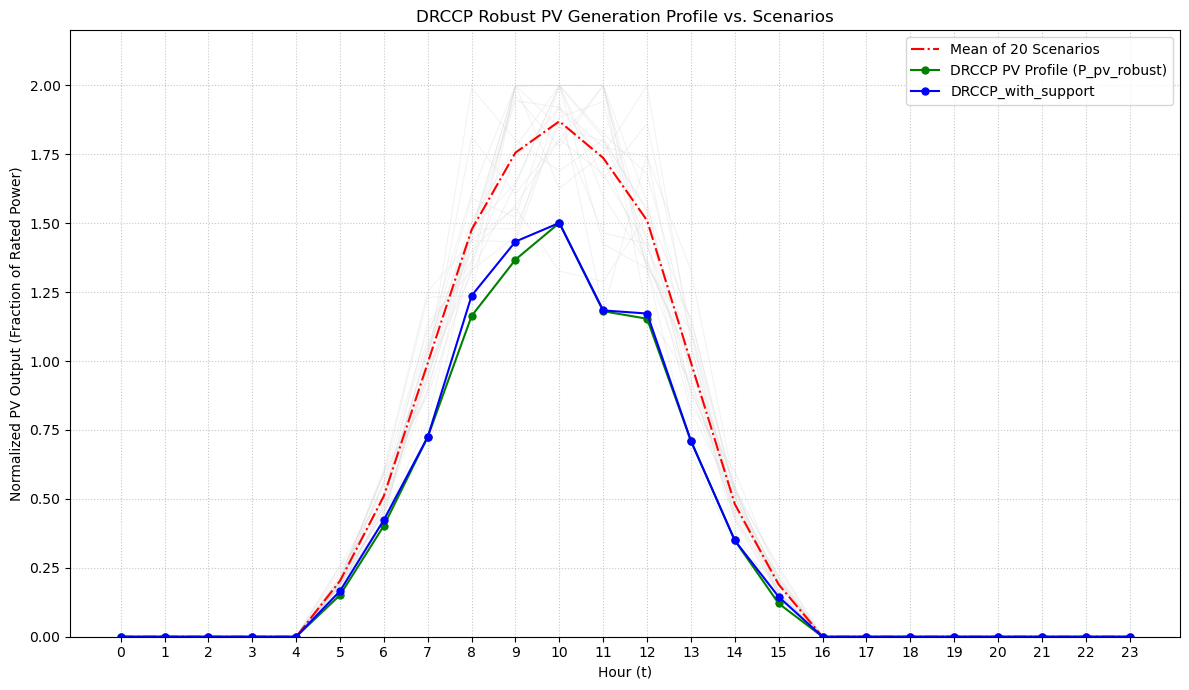

Optimal/Suboptimal objective value (Lower Bound): 8.8271

--- 시간대별 P_pv_robust (합리적 하한) ---
------------------------------------------
| 시간 (t) | P_pv_robust (하한) |
------------------------------------------
|        0 |              0.0000 |
|        1 |              0.0000 |
|        2 |              0.0000 |
|        3 |              0.0000 |
|        4 |              0.0000 |
|        5 |              0.1512 |
|        6 |              0.4028 |
|        7 |              0.7249 |
|        8 |              1.1638 |
|        9 |              1.3682 |
|       10 |              1.5013 |
|       11 |              1.1810 |
|       12 |              1.1537 |
|       13 |              0.7105 |
|       14 |              0.3493 |
|       15 |              0.1206 |
|       16 |              0.0000 |
|       17 |              0.0000 |
|       18 |              0.0000 |
|       19 |              0.0000 |
|       20 |              0.0000 |
|       21 |              0.0000 |
|       22 |          

In [3]:
DRCCP_ALPHA = 0.2
DRCCP_EPSILON = DRCCP_EPSILONS_PER_T # 이전 값 유지
m = gp.Model("DRCCP")

P_pv_robust = m.addVars(T, lb=0, ub=max_norm_profile, name="P_pv_robust")
v_drccp     = m.addVars(T, lb=-gp.GRB.INFINITY, name="v_drccp") # 하한은 유지, 필요시 아래에서 조정
z_drccp     = m.addVars(T, N_SCENARIOS, lb=0, name="z_drccp")
w_drccp     = m.addVars(T, N_SCENARIOS, lb=0, ub=1.0, name="w_drccp")
r_max_drccp = m.addVars(T, N_SCENARIOS, lb=0, name="r_max_drccp")
r_min_drccp = m.addVars(T, N_SCENARIOS, lb=0, name="r_min_drccp")

P_max = np.max(solar_scenarios_normalized, axis=0)
P_min = np.min(solar_scenarios_normalized, axis=0)

# 발전량이 0인 시간대에 P_pv_robust 및 관련 DRCCP 변수를 0으로 고정
for t_idx in T:
    if base_solar_profile_normalized[t_idx] == 0:
        P_pv_robust[t_idx].ub = 0.0 # lb=0이므로 사실상 0으로 고정
        v_drccp[t_idx].lb = 0.0     # v_drccp도 0으로 고정
        v_drccp[t_idx].ub = 0.0
        for s_idx in range(N_SCENARIOS):
            z_drccp[t_idx, s_idx].ub = 0.0
            w_drccp[t_idx, s_idx].ub = 0.0 # lb=0이므로 0으로 고정
            r_max_drccp[t_idx, s_idx].ub = 0.0
            r_min_drccp[t_idx, s_idx].ub = 0.0




m.setObjective(gp.quicksum(P_pv_robust[t] for t in T), gp.GRB.MAXIMIZE)

# 제약조건은 발전량이 있는 시간대에만 적용
for t_idx in T:
    if base_solar_profile_normalized[t_idx] > 0: # 발전량이 있을 때만 DRCCP 제약 적용
        m.addConstr(
            DRCCP_ALPHA * N_SCENARIOS * v_drccp[t_idx] -
            gp.quicksum(z_drccp[t_idx, s_idx] for s_idx in range(N_SCENARIOS)) >=
            DRCCP_EPSILON[t_idx] * N_SCENARIOS,
            name=f"DRCCP_C1_t{t_idx}"
        )

        for s_idx in range(N_SCENARIOS):
            P_hat_km = solar_scenarios_normalized[s_idx, t_idx]
            m.addConstr(
                (-P_pv_robust[t_idx] + P_hat_km) * w_drccp[t_idx, s_idx] -
                (P_max[t_idx]- P_hat_km) * r_max_drccp[t_idx, s_idx] +
                (P_min[t_idx] - P_hat_km) * r_min_drccp[t_idx, s_idx] >=
                v_drccp[t_idx] - z_drccp[t_idx, s_idx],
                name=f"DRCCP_C2_t{t_idx}_s{s_idx}"
            )
            m.addConstr(
                -w_drccp[t_idx, s_idx] - r_max_drccp[t_idx, s_idx] + r_min_drccp[t_idx, s_idx] <= 1,
                name=f"DRCCP_C3a_t{t_idx}_s{s_idx}"
            )
            m.addConstr(
                -w_drccp[t_idx, s_idx] - r_max_drccp[t_idx, s_idx] + r_min_drccp[t_idx, s_idx] >= -1,
                name=f"DRCCP_C3b_t{t_idx}_s{s_idx}"
            )
    # else: # 발전량이 0인 시간대에는 P_pv_robust[t_idx]가 0으로 고정되었고,
            # 다른 v, z, w, r 변수들도 0으로 고정되었으므로,
            # 해당 시간대에 대한 DRCCP 제약조건들은 추가하지 않음.

m.update()
m.params.NonConvex = 2
m.optimize()


if m.status == gp.GRB.OPTIMAL or m.status == gp.GRB.SUBOPTIMAL:
    print(f"Optimal/Suboptimal objective value: {m.ObjVal:.4f}")
    P_pv_robust_values = [P_pv_robust[t].X for t in T]

    plt.figure(figsize=(12, 7))
    num_scenarios_to_plot = min(N_SCENARIOS, 20)
    for i in range(num_scenarios_to_plot):
        plt.plot(T, solar_scenarios_normalized[i, :], color='lightgray', alpha=0.3, linewidth=0.7, label='_nolegend_')
    if N_SCENARIOS > num_scenarios_to_plot:
        plt.plot([], [], color='lightgray', alpha=0.3, linewidth=0.7, label=f'{N_SCENARIOS} Scenarios (subset shown)')

    # plt.plot(T, base_solar_profile_normalized, color='blue', linewidth=2, linestyle='--', label='Base Solar Shape (Normalized)')
    mean_scenario = np.mean(solar_scenarios_normalized, axis=0)
    plt.plot(T, mean_scenario, color='red', linewidth=1.5, linestyle='-.', label=f'Mean of {N_SCENARIOS} Scenarios')
    plt.plot(T, P_pv_robust_values, color='green', linewidth=1.5, marker='o', markersize=5, label='DRCCP PV Profile (P_pv_robust)')
    # supported by P_max and P_min
    #''' 
    for i in T:
        if P_pv_robust_values[i] > P_max[i]:
            P_pv_robust_values[i] = P_max[i]
        if P_pv_robust_values[i] < P_min[i]:
            P_pv_robust_values[i] = P_min[i]
    #'''
    plt.plot(T, P_pv_robust_values, color='blue', linewidth=1.5, marker='o', markersize=5, label='DRCCP_with_support')


    plt.title('DRCCP Robust PV Generation Profile vs. Scenarios')
    plt.xlabel('Hour (t)')
    plt.ylabel('Normalized PV Output (Fraction of Rated Power)')
    plt.xticks(list(T))
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.ylim(bottom=0)
    if max_norm_profile > 0:
        plt.ylim(top=max_norm_profile * 1.1)
    elif np.any(base_solar_profile_normalized > 0):
         plt.ylim(top=max(base_solar_profile_normalized) * 1.1 if max(base_solar_profile_normalized) > 0 else 1.0)
    else:
        plt.ylim(top=1.0)

    plt.tight_layout()
    plt.show()

elif m.status == gp.GRB.INFEASIBLE:
    print("Model is infeasible.")
    print("Computing IIS to identify conflicting constraints...")
    m.computeIIS()
    m.write("model_iis.ilp")
    print("IIS written to model_iis.ilp. Please inspect this file to find the cause of infeasibility.")
elif m.status == gp.GRB.UNBOUNDED:
    print("Model is unbounded.")
else:
    print("Optimization was not successful. Status code:", m.status)

if m.status == gp.GRB.OPTIMAL or m.status == gp.GRB.SUBOPTIMAL:
    print(f"Optimal/Suboptimal objective value (Lower Bound): {m.ObjVal:.4f}")
    P_pv_robust_values = [P_pv_robust[t].X for t in T]

    print("\n--- 시간대별 P_pv_robust (합리적 하한) ---")
    print("------------------------------------------")
    print("| 시간 (t) | P_pv_robust (하한) |")
    print("------------------------------------------")
    for t_idx in T:
        print(f"| {t_idx:8d} | {P_pv_robust_values[t_idx]:19.4f} |")
    print("------------------------------------------\n")


In [23]:
# --------------------------------------------------
# 라이브러리
# --------------------------------------------------
import random
import numpy as np
import gurobipy as gp
import pandapower as pp
from pandapower.powerflow import LoadflowNotConverged
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

# --------------------------------------------------
# 0. 입력 데이터
# --------------------------------------------------
T        = range(24)
T_plus1  = range(len(T) + 1)

bus_data = [(i, 22.9) for i in range(1, 15)]                 # 14-bus, 22.9 kV

load_template = [                                            # (Bus, P, Q)  [MW, MVar]
    (2, 21.7, 12.7), (3, 94.2, 19.0), (4, 47.8, -3.9), (5,  7.6, 0.6),
    (6, 11.2,  7.5), (7,  0.0,  0.0), (8,  0.0, 0.0), (9, 29.5,16.6),
    (10, 9.0,  5.8), (11, 3.5,  1.8), (12, 6.1, 1.6), (13,13.5, 5.8),
    (14,14.9,  5.0),
]

branch_data = [                                              # r, x : Ω  (length_km = 1)
    (1,2,0.01938,0.05917), (1,5,0.05403,0.22304),
    (2,3,0.04699,0.19797), (2,4,0.05811,0.17632), (2,5,0.05695,0.17388),
    (3,4,0.06701,0.17103),
    (4,5,0.01335,0.04211), (4,7,0.00000,0.20912), (4,9,0.00000,0.55618),
    (5,6,0.00000,0.25202),
    (6,11,0.09498,0.19890), (6,12,0.12291,0.25581), (6,13,0.06615,0.13027),
    (7,8,0.00000,0.17615), (7,9,0.00000,0.11001),
    (9,10,0.03181,0.08450), (9,14,0.12711,0.27038),
    (10,11,0.08205,0.19207), (12,13,0.22092,0.19988), (13,14,0.17093,0.34802),
]


# 경제·환경 파라미터
CO2_w=[0.5,0.9]
alpha_co2_cost = 1600
capex_pv_per_mw, capex_ess_per_mwh = 85, 10
P_min, P_max = [0,0], [500,1000]                              # Gen2, Gen3 한계

a = [1,0.9] # 발전기 계수들 a가 이차항
b = [5,3]
c = [10,10]

TOTAL_DEMAND = sum(p for _,p,_ in load_template)

# --------------------------------------------------
# 1단계 : PV·ESS 총용량 & 디스패치 (Gurobi)
# --------------------------------------------------
def optimize_capacity():
    m = gp.Model("stage1")
    m.Params.OutputFlag = 1
    ess_cap = m.addVar(lb=0,  ub=500, name="ESS")            # [MWh]
    pv_size = m.addVar(lb=5,  ub=1000, name="PV")             # [개수]

    P   = m.addVars(2, T, lb={(g,t):P_min[g] for g in range(2) for t in T},
                           ub={(g,t):P_max[g] for g in range(2) for t in T})
    SOE = m.addVars(T_plus1, lb=0)
    ch  = m.addVars(T, lb=0);  dch = m.addVars(T, lb=0)
    sw  = m.addVars(T, vtype=gp.GRB.BINARY)

    cost = (
        gp.quicksum(a[g]*P[g,t]**2 + b[g]*P[g,t] + c[g]            for g in range(2) for t in T) +
        gp.quicksum(alpha_co2_cost*CO2_w[g]*P[g,t]           for g in range(2) for t in T) +
        capex_pv_per_mw  *sum(solar_shape)* pv_size +
        capex_ess_per_mwh* ess_cap
    )
    m.setObjective(cost, gp.GRB.MINIMIZE)
    m.addConstr(SOE[0] == 0)

    for t in T:
        pv_gen = pv_size * P_pv_robust_values[t] * 10 # 스케일링 얼마할지
        m.addConstr(sum(P[g,t] for g in range(2)) + dch[t] + pv_gen ==
                    TOTAL_DEMAND + ch[t])
        m.addConstr(ch[t]  <= sw[t]*ess_cap/4)
        m.addConstr(dch[t] <= (1-sw[t])*ess_cap/4)
        m.addConstr(SOE[t+1] == SOE[t] + 0.97*ch[t] - dch[t]/0.97)
        m.addConstr(SOE[t+1] <= ess_cap)

    m.optimize()

    pv_sel  = pv_size.X
    ess_sel = ess_cap.X
    P_disp  = np.array([[P[g,t].X for t in T] for g in range(2)])
    ch_vals = np.array([ch[t].X  for t in T])
    dch_vals= np.array([dch[t].X for t in T])
    return pv_sel, ess_sel, P_disp, ch_vals, dch_vals

# 1단계
pv_sel, ess_sel, P_disp, ch_vals, dch_vals = optimize_capacity()
print(f"[Stage-1]  PV = {pv_sel:.2f} MW ,  ESS = {ess_sel:.2f} MWh")

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 73 rows, 147 columns and 252 nonzeros
Model fingerprint: 0x234aa800
Model has 48 quadratic objective terms
Model has 48 quadratic constraints
Variable types: 123 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  QMatrix range    [2e-01, 2e-01]
  QLMatrix range   [2e-01, 1e+00]
  Objective range  [1e+01, 1e+05]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [3e+02, 3e+02]
Presolve added 47 rows and 0 columns
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 192 rows, 170 columns, 490 nonzeros
Presolved model has 48 quadratic objective terms
Variable types: 146 continuous, 24 integer (24 binary)
Found heuristic solution: objective 6557146.673


[Stage-2]  최적 ESS 배치
  • Bus  2:  147.90 MWh
  • Bus  3:   18.52 MWh
  • Bus  4:    0.00 MWh
  • Bus  5:  115.56 MWh
  • Bus  6:   89.97 MWh
  • Bus  7:   11.35 MWh
  • Bus  8:   20.66 MWh
  • Bus  9:    1.48 MWh
  • Bus 10:    5.02 MWh
  • Bus 11:    0.00 MWh
  • Bus 12:    0.56 MWh
  • Bus 13:    4.21 MWh
  • Bus 14:   13.78 MWh
  Σ = 429.02 MWh  (≡ Stage-1 ESS)


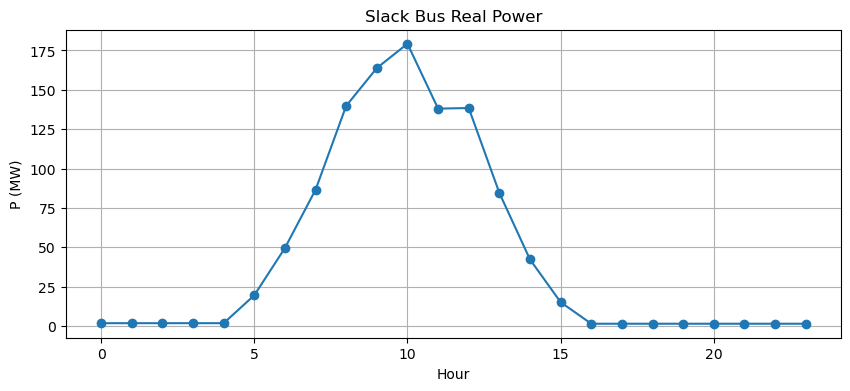

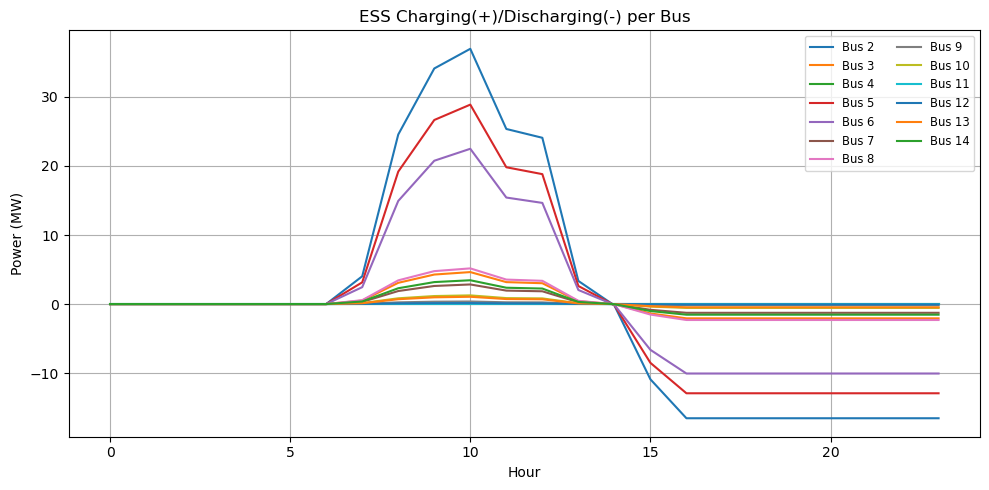

In [24]:
# --------------------------------------------------
# 2단계 : ESS 분산 배치 (GA)
# --------------------------------------------------
def distribute_ess(pv_sel, ess_sel, P_disp, ch, dch,
                   pop_size=40, ngen=20, seed=42):

    random.seed(seed)
    try:
        creator.FitnessMin
    except AttributeError:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

    N_BUS = len(load_template)
    toolbox = base.Toolbox()
    toolbox.register("attr", random.random)
    toolbox.register("individual", tools.initRepeat,
                     creator.Individual, toolbox.attr, n=N_BUS)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # ---------- 파워플로우 ----------
    def run_pf(hour, ess_alloc):
        net = pp.create_empty_network()
        buses = {b: pp.create_bus(net, vn_kv=kv) for b,kv in bus_data}
        pp.create_ext_grid(net, buses[1], vm_pu=1.05)
        # 발전기 2,3
        pp.create_gen(net, buses[2], p_mw=P_disp[0][hour],
                      vm_pu=1.05, min_q_mvar=-40, max_q_mvar=50)
        pp.create_gen(net, buses[3], p_mw=P_disp[1][hour],
                      vm_pu=1.05, min_q_mvar=-40, max_q_mvar=50)
        # PV (Bus 6)
        pv_gen = pv_sel * solar_shape[hour] / 100.0
        pp.create_gen(net, buses[6], p_mw=pv_gen,
                      vm_pu=1.05, min_q_mvar=0, max_q_mvar=0)

        net_ess_flow = ch[hour] - dch[hour]                 # + 충전, – 방전
        share = ess_alloc / ess_sel if ess_sel else np.zeros_like(ess_alloc)
        for (bus, Pd, Qd), s in zip(load_template, share):
            pp.create_load(net, buses[bus],
                           p_mw=Pd + s*net_ess_flow, q_mvar=Qd)
        for f,t,r,x in branch_data:
            pp.create_line_from_parameters(net, buses[f], buses[t],
                length_km=1, r_ohm_per_km=r, x_ohm_per_km=x,
                c_nf_per_km=0, max_i_ka=1)
        try:
            pp.runpp(net, init='flat', max_iteration=20)
            return abs(net.res_ext_grid.p_mw.iloc[0])        # Slack P
        except LoadflowNotConverged:
            return 1e6                                       # Penalty

    # ---------- 평가 함수 ----------
    def repair(ind):
        arr = np.maximum(0, np.array(ind, dtype=float))
        if arr.sum() == 0:
            arr[:] = 1.0
        ind[:] = arr                                        # in-place 수정
        return ind

    def evaluate(ind):
        repair(ind)
        frac   = np.array(ind) / sum(ind)
        alloc  = frac * ess_sel
        return (sum(run_pf(t, alloc) for t in T),)

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate",   tools.cxBlend,     alpha=0.4)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(pop_size)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.3,
                        ngen=ngen, halloffame=hof, verbose=False)

    best    = hof[0]
    frac    = np.array(best) / sum(best)
    alloc   = frac * ess_sel
    return alloc

# --------------------------------------------------
# 3단계 : 시각화
# --------------------------------------------------
def visualize(best_alloc, pv_sel, ess_sel, P_disp, ch, dch):
    net_ess_flow = ch - dch                                 # len 24
    ess_power    = best_alloc[:,None] / ess_sel * net_ess_flow  # (bus, time)

    # Slack-bus P 곡선
    slack_series = []
    for t in T:
        # 간단히 build_pf 재사용
        net = pp.create_empty_network()
        buses = {b: pp.create_bus(net, vn_kv=kv) for b,kv in bus_data}
        pp.create_ext_grid(net, buses[1], vm_pu=1.05)
        pp.create_gen(net, buses[2], p_mw=P_disp[0][t],
                      vm_pu=1.05, min_q_mvar=-40, max_q_mvar=50)
        pp.create_gen(net, buses[3], p_mw=P_disp[1][t],
                      vm_pu=1.05, min_q_mvar=-40, max_q_mvar=50)
        pv_gen = pv_sel * solar_shape[t] / 100.0
        pp.create_gen(net, buses[6], p_mw=pv_gen,
                      vm_pu=1.05, min_q_mvar=0, max_q_mvar=0)

        share = best_alloc / ess_sel if ess_sel else np.zeros_like(best_alloc)
        for (bus,Pd,Qd),s in zip(load_template, share):
            pp.create_load(net, buses[bus], p_mw=Pd + s*net_ess_flow[t], q_mvar=Qd)
        for f,tb,r,x in branch_data:
            pp.create_line_from_parameters(net, buses[f], buses[tb],
                                           length_km=1, r_ohm_per_km=r,
                                           x_ohm_per_km=x, c_nf_per_km=0,
                                           max_i_ka=1)
        pp.runpp(net, init='flat', max_iteration=20)
        slack_series.append(abs(net.res_ext_grid.p_mw.iloc[0]))

    # ---------- Plot ----------
    plt.figure(figsize=(10,4))
    plt.plot(T, slack_series, marker='o')
    plt.title("Slack Bus Real Power")
    plt.xlabel("Hour"); plt.ylabel("P (MW)")
    plt.grid(True)

    plt.figure(figsize=(10,5))
    for row,(bus,_,_) in zip(ess_power, load_template):
        plt.plot(T, row, label=f"Bus {bus}")
    plt.title("ESS Charging(+)/Discharging(-) per Bus")
    plt.xlabel("Hour"); plt.ylabel("Power (MW)")
    plt.legend(ncol=2, fontsize='small'); plt.grid(True)

    plt.tight_layout(); plt.show()

# --------------------------------------------------
# main
# --------------------------------------------------

# 2단계
best_alloc = distribute_ess(pv_sel, ess_sel, P_disp,
                            ch_vals, dch_vals,
                            pop_size=30, ngen=20)
print("\n[Stage-2]  최적 ESS 배치")
for (bus,_,_),cap in zip(load_template, best_alloc):
    print(f"  • Bus {bus:>2}: {cap:7.2f} MWh")
print(f"  Σ = {best_alloc.sum():.2f} MWh  (≡ Stage-1 ESS)")

# 3단계
visualize(best_alloc, pv_sel, ess_sel, P_disp, ch_vals, dch_vals)